# 2024 OIBC Challenge
**(Deep Learning version final)**

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import os
from datetime import datetime, timedelta

import torch
from torch.utils.data import DataLoader
from DL_final import NeuralNetwork, ElecDataset

## 데이터 전처리

In [2]:
print(os.getcwd())  # 현재 작업 경로 출력

f:\For me\Project\24-OIBC-WolgoksTears\personal_files\hoon


actual_weather_1

In [10]:
# 데이터 불러오기
actual_weather_1 = pd.read_csv("../../data_files/actual_weather_1.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
actual_weather_1['datetime'] = pd.to_datetime(actual_weather_1['ts'], unit='s')
actual_weather_1['datetime'] = actual_weather_1['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거
actual_weather_1.drop(columns=['ts'], inplace=True)
actual_weather_1.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열) -> location을 없애서 시간별로 중복되는 값이 있기 때문
actual_weather_1 = actual_weather_1.groupby(['datetime'], as_index=False).mean()


# weather_forecast에 없는 columns 제거
actual_weather_1.drop(columns=['real_feel_temp_shade'], inplace=True)
actual_weather_1.drop(columns=['pressure'], inplace=True)
actual_weather_1.drop(columns=['appr_temp'], inplace=True)
actual_weather_1.drop(columns=['wind_chill_temp'], inplace=True)
 
# 결과 확인
actual_weather_1.head()

,datetime,temp,real_feel_temp,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,wet_bulb_temp,precip_1h
0,2024-03-01 00:00:00,8.500000,8.000000,81.000000,5.500000,270.000000,6.100000,17.600000,0.0,20.900000,91.000000,579.000000,7.100000,0.100000
1,2024-03-01 01:00:00,7.158333,3.041667,72.666667,2.508333,234.666667,20.483333,26.366667,0.0,20.783333,97.750000,693.416667,5.091667,0.008333
2,2024-03-01 02:00:00,6.477778,2.111111,75.666667,2.433333,262.888889,21.944444,27.433333,0.0,20.033333,86.333333,616.222222,4.733333,0.011111
3,2024-03-01 03:00:00,6.045455,0.900000,74.545455,1.663636,213.000000,22.490909,27.645455,0.0,19.900000,62.818182,8692.363636,4.209091,0.136364
4,2024-03-01 04:00:00,5.430000,-0.090000,68.100000,-0.030000,256.800000,26.140000,42.440000,0.0,23.800000,38.100000,10911.800000,3.180000,0.410000


weather_forecast_1

In [11]:
# 데이터 불러오기
weather_forecast_1 = pd.read_csv("../../data_files/weather_forecast_1.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
weather_forecast_1['datetime'] = pd.to_datetime(weather_forecast_1['ts'], unit='s')
weather_forecast_1['datetime'] = weather_forecast_1['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열 제거, 'base_ts' 열 제거, 'location' 제거
weather_forecast_1.drop(columns=['ts'], inplace=True)
weather_forecast_1.drop(columns=['base_ts'], inplace=True)
weather_forecast_1.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
weather_forecast_1 = weather_forecast_1.groupby(['datetime'], as_index=False).mean()


# 예보 데이터의 columns 순서를 actual_weather columns 순서와 맞추기
weather_forecast_1 = weather_forecast_1[['datetime', 'temp', 'real_feel_temp', 'rel_hum',
       'dew_point', 'wind_dir', 'wind_spd', 'wind_gust_spd', 'uv_idx', 'vis',
       'cld_cvr', 'ceiling', 'wet_bulb_temp', 'total_liq']]
weather_forecast_1['precip_1h'] = weather_forecast_1['total_liq']
weather_forecast_1.drop(columns=['total_liq'], inplace=True)  

# 결과 확인
weather_forecast_1.head()

,datetime,temp,real_feel_temp,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,wet_bulb_temp,precip_1h
0,2024-03-02 00:00:00,1.728394,-4.320987,64.333333,-4.320987,335.555556,22.048022,50.604944,0.0,16.093400,75.555556,1700.106667,-0.555556,0.000000
1,2024-03-02 01:00:00,1.851852,-4.506173,64.333333,-4.135800,335.000000,22.048022,50.640711,0.0,15.378140,84.777778,1249.680000,-0.432099,0.056444
2,2024-03-02 02:00:00,1.790123,-5.061728,66.333333,-3.950616,334.444444,22.656000,51.481144,0.0,14.392882,89.333333,1229.360000,-0.370370,0.197556
3,2024-03-02 03:00:00,1.604940,-5.308640,67.333333,-3.888887,333.777778,23.263967,51.463267,0.0,15.195758,94.555556,1933.786667,-0.370370,0.084667
4,2024-03-02 04:00:00,1.851852,-4.876541,66.444444,-3.950616,333.888889,23.871922,50.837400,0.0,15.825200,82.555556,2600.960000,-0.308642,0.000000


actual_weather_2

In [12]:
# 데이터 불러오기
actual_weather_2 = pd.read_csv("../../data_files/actual_weather_2.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
actual_weather_2['datetime'] = pd.to_datetime(actual_weather_2['ts'], unit='s')
actual_weather_2['datetime'] = actual_weather_2['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거
actual_weather_2.drop(columns=['ts'], inplace=True)
actual_weather_2.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
actual_weather_2 = actual_weather_2.groupby(['datetime'], as_index=False).mean()
 
# 결과 확인
actual_weather_2.head()

,datetime,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow
0,2024-03-01 00:00:00,89.333333,6.146667,6.146667,6.146667,74.666667,1022.666667,8.553333,345.333333,0.17,0.0
1,2024-03-01 01:00:00,83.500000,6.255000,6.255000,6.255000,70.500000,1022.500000,6.256667,342.000000,0.00,0.0
2,2024-03-01 02:00:00,84.333333,5.926667,5.926667,5.926667,67.833333,1022.833333,7.291667,343.000000,0.21,0.0
3,2024-03-01 03:00:00,83.666667,5.198333,5.198333,5.198333,63.833333,1023.500000,7.520000,342.333333,0.00,0.0
4,2024-03-01 04:00:00,42.166667,4.433333,4.433333,4.433333,64.833333,1023.833333,7.330000,342.000000,0.00,0.0


weather_forecast_2

In [13]:
# 데이터 불러오기
weather_forecast_2 = pd.read_csv("../../data_files/weather_forecast_2.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
weather_forecast_2['datetime'] = pd.to_datetime(weather_forecast_2['ts'], unit='s')
weather_forecast_2['datetime'] = weather_forecast_2['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거, 'base_ts' 제거
weather_forecast_2.drop(columns=['ts'], inplace=True)
weather_forecast_2.drop(columns=['location'], inplace=True)
weather_forecast_2.drop(columns=['base_ts'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
weather_forecast_2 = weather_forecast_2.groupby(['datetime'], as_index=False).mean()
 
# 결과 확인
weather_forecast_2.head()

,datetime,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow
0,2024-03-02 00:00:00,100.000000,1.213333,1.213333,1.213333,60.333333,1027.000000,8.306667,332.333333,0.0,0.0
1,2024-03-02 01:00:00,100.000000,1.280000,1.280000,1.280000,61.000000,1027.000000,8.043333,333.666667,0.0,0.0
2,2024-03-02 02:00:00,100.000000,1.323333,1.323333,1.323333,60.666667,1026.666667,7.626667,333.000000,0.0,0.0
3,2024-03-02 03:00:00,100.000000,1.323333,1.323333,1.323333,60.666667,1026.000000,7.310000,332.666667,0.0,0.0
4,2024-03-02 04:00:00,96.333333,1.356667,1.356667,1.356667,60.666667,1026.000000,7.076667,331.666667,0.0,0.0


elec_supply

In [7]:
# 데이터 불러오기
elec_supply = pd.read_csv("../../data_files/elec_supply.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
elec_supply['datetime'] = pd.to_datetime(elec_supply['ts'], unit='s')
elec_supply['datetime'] = elec_supply['datetime'].dt.round('h') + timedelta(hours=9)

# 1시간 단위로 그룹화하여 평균을 계산
elec_supply = elec_supply.groupby(['datetime'], as_index=False).mean()

# 결과 확인
elec_supply.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
elec_supply.head()

,datetime,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
0,2024-01-01 00:00:00,1.285000e+06,757500.000000,0.0,115593.233333,123350.666667,527166.666667,328500.000000
1,2024-01-01 01:00:00,1.238308e+06,727538.461538,0.0,68802.153846,77036.569231,510692.307692,312692.307692
2,2024-01-01 02:00:00,1.214818e+06,694090.909091,0.0,45923.181818,53740.109091,520727.272727,318545.454545
3,2024-01-01 03:00:00,1.207923e+06,672000.000000,0.0,38567.161538,46614.815385,536000.000000,291000.000000
4,2024-01-01 04:00:00,1.192364e+06,666000.000000,0.0,22849.272727,30575.990909,526363.636364,318272.727273


smp_da

In [14]:
# 데이터 불러오기
smp_da = pd.read_csv("../../data_files/smp_da.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
smp_da['datetime'] = pd.to_datetime(smp_da['ts'], unit='s') + timedelta(hours=9)

# 결과 확인
smp_da.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
smp_da.head()

,하루전가격(원/kWh),datetime
0,107.39,2024-03-01 00:00:00
1,107.39,2024-03-01 01:00:00
2,95.30,2024-03-01 02:00:00
3,87.89,2024-03-01 03:00:00
4,0.00,2024-03-01 04:00:00


smp_rt_rc

In [15]:
# 데이터 불러오기
smp_rt_rc = pd.read_csv("../../data_files/smp_rt_rc.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
smp_rt_rc['datetime'] = pd.to_datetime(smp_rt_rc['ts'], unit='s')
smp_rt_rc['datetime'] = smp_rt_rc['datetime'].dt.round('h') + timedelta(hours=9)

# 1시간 단위로 그룹화하여 평균을 계산
smp_rt_rc = smp_rt_rc.groupby(['datetime'], as_index=False).mean()

# 결과 확인
smp_rt_rc.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
smp_rt_rc.head()

,datetime,실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh)
0,2024-03-01 00:00:00,95.30,95.30
1,2024-03-01 01:00:00,107.39,107.39
2,2024-03-01 02:00:00,95.30,95.30
3,2024-03-01 03:00:00,87.89,87.89
4,2024-03-01 04:00:00,86.50,86.50


### 날짜 설정

In [27]:
# 예측할 날짜
# 10일 오전 11시까지 제출할거면 11일걸 예측해야하므로 '2024-11-11'

predict_target_date = '2024-11-11'

##### X 데이터

- 제주 기상 예측 1 (n+1)
- 제주 기상 예측 2 (n+1)
- 하루 전 시장 전기 예측 (n)
- 제주 전력 시장 실시간 (n-1)
- 제주 전력 시장 현황 (n-1)

In [21]:
# 기상 예측 데이터에 맞춰서 프로그램을 만들 것이므로 이 시간에 맞도록 시간 조정
# 기상 예측이 n+1일이므로 n일은 +1, n-1일은 +2를 해서 맞춰줬다.
 
actual_weather_1
actual_weather_2
weather_forecast_1
weather_forecast_2
smp_da_x = smp_da.copy()
smp_da_x['datetime'] += pd.Timedelta(days=1)
smp_rt_rc['datetime'] += pd.Timedelta(days=2)
elec_supply['datetime'] += pd.Timedelta(days=2)

In [ ]:
dfs = [weather_forecast_1, weather_forecast_2, smp_da_x, smp_rt_rc, elec_supply]

#dfs 리스트를 하나씩 빼와서 datetime이 일치하는 것들 모두 병합(reduce와 lambda로 간단하게)
test_data = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='inner'), dfs)

target_day = datetime.strptime(predict_target_date, '%Y-%m-%d')

#target_day의 모든 데이터 불러오기(01시부터 24시까지 총 24개)
target_data = test_data.loc[
  (test_data['datetime'] > target_day) &
  (test_data['datetime'] <= target_day + timedelta(days=1))
]

In [29]:
target_data

,datetime,temp_x,real_feel_temp,rel_hum,dew_point,wind_dir_x,wind_spd,wind_gust_spd,uv_idx,vis,...,하루전가격(원/kWh),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
5937,2024-11-11 01:00:00,16.111111,14.506167,87.666667,13.888856,61.444444,13.393344,27.394622,0.0,11.265400,...,98.10,97.946000,97.946000,1.033077e+06,555769.230769,0.000000,95558.038462,96128.938462,477307.692308,302769.230769
5938,2024-11-11 02:00:00,15.802478,14.197522,87.000000,13.641956,54.444444,13.393344,26.786644,0.0,11.265400,...,78.40,89.390000,89.390000,1.036636e+06,535727.272727,0.000000,98823.936364,99451.436364,501000.000000,326363.636364
5939,2024-11-11 03:00:00,15.493844,14.012344,86.444444,13.271600,88.666667,13.196644,25.767411,0.0,13.947622,...,78.40,89.426000,89.426000,1.003538e+06,519461.538462,0.000000,65162.207692,65682.846154,484230.769231,309461.538462
5940,2024-11-11 04:00:00,15.185189,13.518511,86.000000,12.839489,163.666667,13.822500,25.981978,0.0,16.093400,...,78.40,89.480000,89.480000,9.846364e+05,508181.818182,0.000000,46135.509091,46656.654545,476090.909091,296363.636364
5941,2024-11-11 05:00:00,14.814811,12.962944,85.000000,12.345678,160.666667,14.430478,26.375356,0.0,16.093400,...,78.40,94.552000,94.552000,9.938462e+05,522153.846154,0.000000,55229.038462,55749.553846,471692.307692,291000.000000
5942,2024-11-11 06:00:00,14.876533,13.086422,82.555556,11.913578,159.000000,14.430478,26.572056,0.0,16.093400,...,78.40,106.266667,106.266667,9.927273e+05,550000.000000,0.000000,54106.800000,54626.809091,442727.272727,264090.909091
5943,2024-11-11 07:00:00,14.814811,13.209867,82.111111,11.913578,157.777778,14.233778,26.572056,0.0,16.093400,...,80.24,111.784000,111.784000,9.790000e+05,583076.923077,0.000000,40930.476923,41549.153846,395923.076923,219000.000000
5944,2024-11-11 08:00:00,15.493833,14.876556,79.555556,12.037044,157.777778,14.019200,26.357478,1.0,16.093400,...,90.77,111.106667,111.106667,9.884545e+05,585000.000000,24863.999091,26232.209091,51556.045455,403363.636364,226909.090909
5945,2024-11-11 09:00:00,16.419767,16.666667,75.555556,12.098767,159.777778,13.804622,26.572044,2.0,16.093400,...,90.68,125.188000,125.188000,1.081000e+06,561769.230769,123433.684615,21265.369231,145158.600000,518923.076923,344076.923077
5946,2024-11-11 10:00:00,17.469133,18.271589,71.222222,12.222211,80.555556,14.019200,25.356122,3.0,16.093400,...,92.45,142.496667,142.496667,1.171455e+06,555818.181818,217665.363636,19137.909091,237262.181818,615454.545455,431363.636364


In [30]:
# 어짜피 예측할거기 때문에 Y는 형식만 맞추기
Y = smp_da

predict_set = ElecDataset(target_data, Y.iloc[:24])

predict_dataloader = DataLoader(dataset=predict_set,
                        batch_size=24,
                        shuffle=False)

c:\Users\gdy02\Desktop\월곡의 눈물\personal_files\hoon\DL_final.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[columns_to_scale] = scaler.fit_transform(x_data[columns_to_scale])


## 파이토치 모델 예측

### 모델 구성

In [16]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NVIDIA GeForce GTX 1650
2.5.0+cu118
11.8
tensor([0.1296], device='cuda:0')


device(type='cuda', index=0)

In [17]:
input_size = len(target_data.columns) - 1  # Number of input features
output_size = 1  # Single output

model_test = NeuralNetwork(input_size, output_size)

model_test.to(device)

model_test.load_state_dict(torch.load('smp_model.pth'))

C:\Users\ldh75\AppData\Local\Temp\ipykernel_36040\757319830.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load('smp_model.pth'))


<All keys matched successfully>

## 예측

In [18]:
model_test.eval()

with torch.no_grad():
  for inputs, _ in predict_dataloader:
    inputs = inputs.to(device)
    predictions = model_test(inputs)

print(predictions)

tensor([[ 27.2918],
        [  0.4216],
        [  0.4851],
        [  0.4863],
        [  0.8215],
        [ 36.2212],
        [115.2028],
        [ 99.8965],
        [122.4531],
        [166.3575],
        [155.7002],
        [150.3380],
        [137.5393],
        [149.6008],
        [150.5255],
        [158.3756],
        [176.4105],
        [177.5971],
        [192.8456],
        [178.8293],
        [204.7542],
        [202.2849],
        [194.3303],
        [177.4139]], device='cuda:0', dtype=torch.float64)


In [19]:
flattened_list = predictions.view(-1).tolist()

print(flattened_list)

[27.291771910893104, 0.4216326060323219, 0.4850544901846343, 0.48627374448910343, 0.8214548325640538, 36.22119380298354, 115.20283298710159, 99.89652020861898, 122.45310544872889, 166.3575170570513, 155.7001859939244, 150.3379506663673, 137.53930998982167, 149.60080817589946, 150.52550703412808, 158.37560607072265, 176.41053138127543, 177.59712856813516, 192.84562531212558, 178.82931709865838, 204.7541889771372, 202.28486152914962, 194.33033585571727, 177.41391023331786]


##### 분석

예측결과

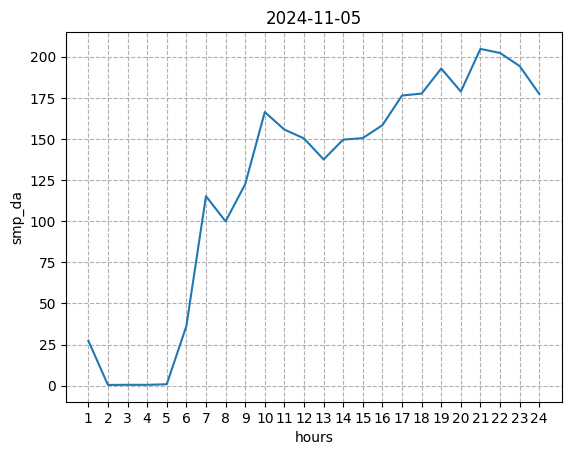

In [20]:
plt.plot(list(range(1, 25)), flattened_list)

plt.title(predict_target_date)
plt.xlabel('hours')
plt.ylabel('smp_da')
plt.xticks(list(range(1,25, 1)))
plt.grid(True, linestyle='--')

plt.show()